### Импорт библиотек, настройка



In [37]:
import torch
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import glob
import torch.nn.functional as F
from glob import glob
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict

In [38]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.2
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 Ti


### Create DataSet, Preproccesing, Augmentation, DataLoader


In [39]:
# Пути данных
TRAIN_DATA = "C:\\Users\\minik\\Desktop\\datasets\\instanse\\train"
TRAIN_AUG = "C:\\Users\\minik\\Desktop\\datasets\\instanse\\train_aug"
VAL_DATA = "C:\\Users\\minik\\Desktop\\datasets\\instanse\\val"
TEST_DATA = "C:\\Users\\minik\\Desktop\\datasets\\instanse\\test"


In [40]:
#mask_16 = "C:\\Users\\minik\\Desktop\\datasets\\Instanse\\masks\\16\\"
#list = os.listdir(mask_16)
#list
#for i in list[:2]:
#    path = os.path.join(mask_16 + i)
#    img = cv2.imread(path)
#    plt.imshow(img)

In [43]:
transform_set = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])

#Создаем класс для создания датасета, в котором используем аугментацию
#данных с помощью библиотеки Albumentation
class CustomDataset(Dataset):
    def __init__(self, img_path, msk_path, transform_set = transform_set):
        self.images_paths = os.path.join(img_path, 'images')
        self.masks_paths = os.path.join(msk_path, 'masks\\Tubulitis')
        self.image_filenames = sorted(list(set(os.listdir(self.masks_paths)) - {'desktop.ini'}))
        self.transform_set = transform_set


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.images_paths, image_name)
        mask_path = os.path.join(self.masks_paths, image_name)


        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256,256))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256,256))

        mask = np.where(mask<129, 1, 0).astype('float32')

        # Normalize images and masks
        if self.transform_set!=None:
            image = self.transform_set(image)
        #image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)


        return image, mask

In [ ]:
# Создаем датасеты для обучения
from torch.utils.data import ConcatDataset

orig_train_dataset = CustomDataset(
    img_path=TRAIN_DATA,
    msk_path=TRAIN_DATA,
    transform_set=transform_set
)

aug_train_dataset = CustomDataset(
    img_path=TRAIN_AUG,
    msk_path=TRAIN_AUG,
    transform_set=transform_set
)

train_dataset = ConcatDataset([orig_train_dataset,aug_train_dataset])


val_dataset = CustomDataset(
    img_path=VAL_DATA,
    msk_path=VAL_DATA,
    transform_set=transform_set
)
test_dataset = CustomDataset(
    img_path=TEST_DATA,
    msk_path=TEST_DATA,
    transform_set=transform_set
)

In [6]:
def my_collate_fn(batch):
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    return torch.stack(images), torch.stack(masks)

In [7]:
test_dataset[5]

(tensor([[[0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9137],
          [0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9137],
          [0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9137],
          ...,
          [0.6157, 0.6784, 0.7333,  ..., 0.8588, 0.9765, 0.8824],
          [0.6157, 0.6784, 0.7333,  ..., 0.8902, 0.9059, 0.8980],
          [0.6157, 0.6784, 0.7333,  ..., 0.8980, 0.8902, 0.9059]],
 
         [[0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9137],
          [0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9059],
          [0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9059],
          ...,
          [0.1765, 0.3098, 0.4902,  ..., 0.8275, 0.9608, 0.8510],
          [0.3882, 0.3882, 0.5059,  ..., 0.8667, 0.8902, 0.8510],
          [0.3176, 0.3412, 0.4980,  ..., 0.8588, 0.8745, 0.8510]],
 
         [[0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9059],
          [0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9059],
          [0.9137, 0.9137, 0.9137,  ...,

In [8]:
np.unique(train_dataset[124][1])

array([0., 1.], dtype=float32)

In [45]:
# Создаем генераторы изображений для последовательной подачи в модель
# для тренировки, чтобы избежать ошибок с оперативной памятью и улучшить
# скорость обучения

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=my_collate_fn)


val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=my_collate_fn)


test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=my_collate_fn)


In [10]:
img, lab = next(iter(train_dataloader))
print(img.shape)
print(lab.shape)
print(img)
print(lab)


torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
tensor([[[[ 0.6235,  0.5373,  0.5373,  ...,  0.7647,  0.6471,  0.6471],
          [ 0.5608,  0.5529,  0.5529,  ...,  0.7020,  0.6863,  0.6863],
          [ 0.5373,  0.5373,  0.4510,  ...,  0.6549,  0.5451,  0.5451],
          ...,
          [ 0.3725,  0.4824,  0.4039,  ..., -0.0039,  0.0667,  0.0667],
          [ 0.3333,  0.3725,  0.4353,  ..., -0.0510,  0.0196,  0.0196],
          [ 0.3333,  0.3725,  0.4353,  ..., -0.0510,  0.0196,  0.0196]],

         [[ 0.6784,  0.5529,  0.4667,  ...,  0.6000,  0.4510,  0.4510],
          [ 0.6392,  0.6000,  0.4902,  ...,  0.5216,  0.5529,  0.5529],
          [ 0.5059,  0.5686,  0.4431,  ...,  0.4667,  0.3725,  0.3725],
          ...,
          [ 0.3725,  0.4745,  0.3569,  ..., -0.2627, -0.1843, -0.1843],
          [ 0.3412,  0.3333,  0.4196,  ..., -0.3412, -0.2863, -0.2863],
          [ 0.3412,  0.3333,  0.4196,  ..., -0.3412, -0.2863, -0.2863]],

         [[ 0.6784,  0.6235,  0.4824,  ..., 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


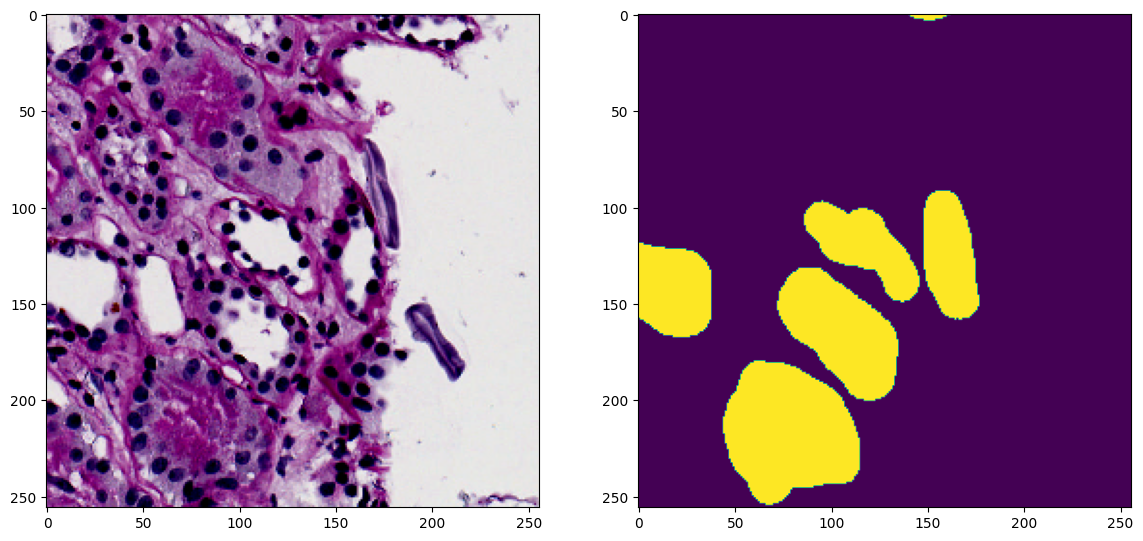

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


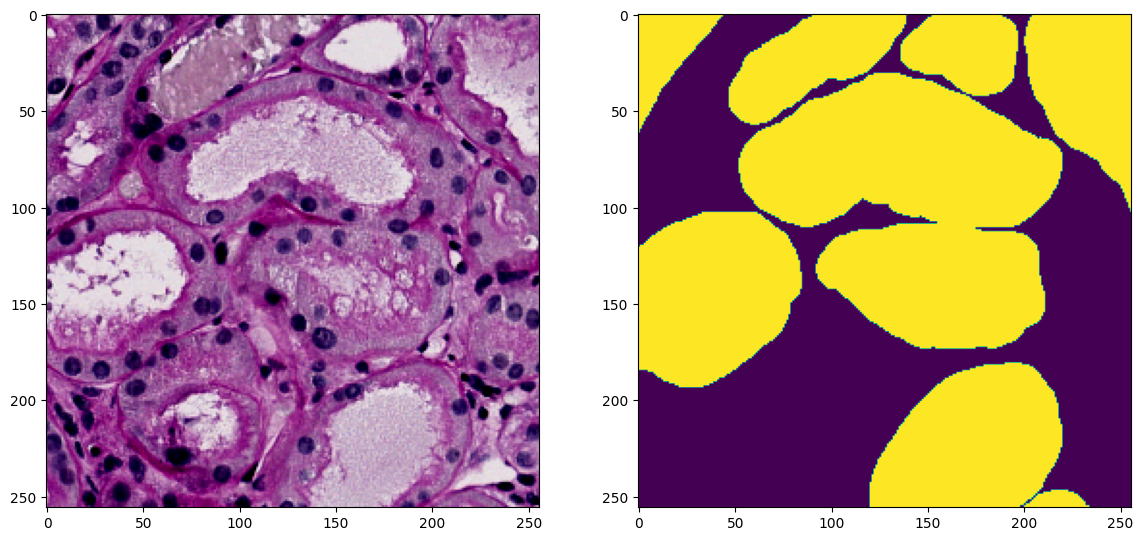

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


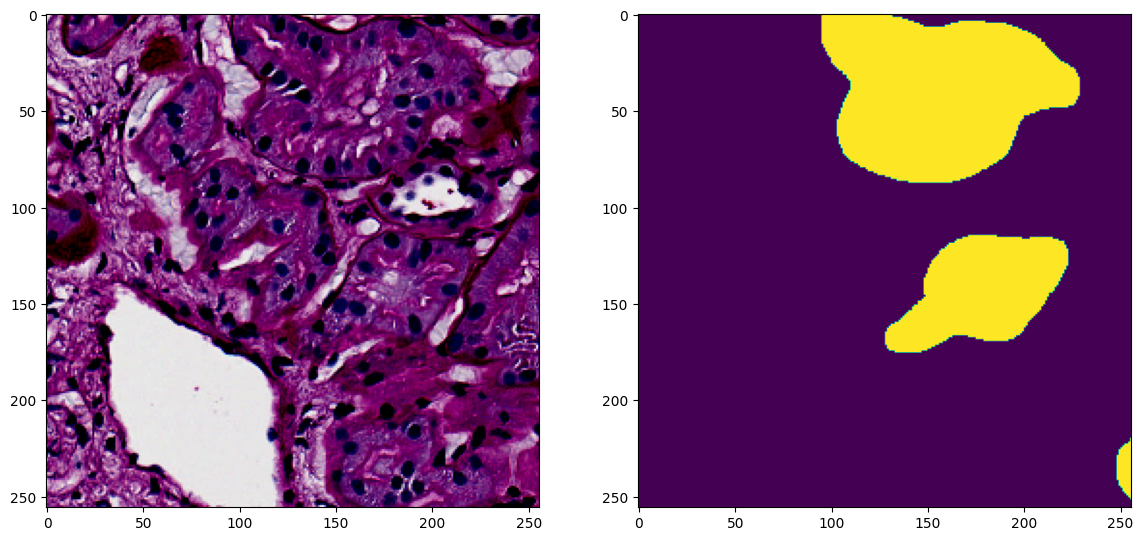

In [46]:
# lets look at some samples
image, mask = train_dataset[5]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

image, mask = val_dataset[5]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

image, mask = test_dataset[5]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

### С этого момента неообходимо выбрать Архитектуру нейросети и произвести ее настройку


Семантическая бинарная сегментация

In [12]:
#!pip install -U segmentation-models-pytorch
#!pip install -U -q pytorch-lightning
import segmentation_models_pytorch as smp
import pytorch_lightning as pl


In [13]:
device = torch.device("cuda")
device

device(type='cuda')

In [17]:
arch = 'unet'
enc_name = 'resnet50'
classes = 1

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = smp.losses.DiceLoss(mode='binary')
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_{arch}',
                                   filename = arch, 
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')

In [18]:
class Tubuli(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        #print(out)
        #print(mask)
        loss = self.criterion(out, mask.long())
        #loss.requires_grad = True

        tp, fp, fn, tn = smp.metrics.get_stats(out, mask.long(), mode='binary', threshold=0.5)
        recall =smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True) 
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_Recall", recall, prog_bar=True, on_epoch=True)
        
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    def configure_optimizers(self):
        return self.optimizer

In [19]:
pl_model = Tubuli(model, optimizer, criterion)
trainer = pl.Trainer(max_epochs=50, callbacks=cbs, accelerator='auto')
trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\minik\anaconda3\envs\PyTorch\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\minik\Desktop\Project\Unet\checkpoints\checkpoints_unet\checkpoints_unet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | Unet     | 32.5 M
1 | criterion | DiceLoss | 0     
---------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 5048/5048 [08:56<00:00,  9.40it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.525, valid_IoU=0.326, valid_Recall=0.675, train_loss_epoch=0.148, train_IoU_epoch=0.114, train_Recall_epoch=0.963]

Epoch 0, global step 5048: 'valid_loss' reached 0.52455 (best 0.52455), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 1: 100%|██████████| 5048/5048 [08:55<00:00,  9.42it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.570, valid_IoU=0.291, valid_Recall=0.718, train_loss_epoch=0.129, train_IoU_epoch=0.230, train_Recall_epoch=0.962]    

Epoch 1, global step 10096: 'valid_loss' was not in top 1


Epoch 2: 100%|██████████| 5048/5048 [08:55<00:00,  9.42it/s, v_num=194, train_loss_step=0.246, train_IoU_step=0.319, train_Recall_step=0.976, valid_loss=0.502, valid_IoU=0.344, valid_Recall=0.636, train_loss_epoch=0.124, train_IoU_epoch=0.259, train_Recall_epoch=0.962]   

Epoch 2, global step 15144: 'valid_loss' reached 0.50200 (best 0.50200), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 3: 100%|██████████| 5048/5048 [08:54<00:00,  9.44it/s, v_num=194, train_loss_step=0.312, train_IoU_step=0.762, train_Recall_step=0.972, valid_loss=0.506, valid_IoU=0.349, valid_Recall=0.899, train_loss_epoch=0.118, train_IoU_epoch=0.267, train_Recall_epoch=0.964]    

Epoch 3, global step 20192: 'valid_loss' was not in top 1


Epoch 4: 100%|██████████| 5048/5048 [08:53<00:00,  9.46it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.462, valid_IoU=0.389, valid_Recall=0.818, train_loss_epoch=0.115, train_IoU_epoch=0.269, train_Recall_epoch=0.968]   

Epoch 4, global step 25240: 'valid_loss' reached 0.46177 (best 0.46177), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 5: 100%|██████████| 5048/5048 [08:52<00:00,  9.47it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.594, valid_IoU=0.291, valid_Recall=0.923, train_loss_epoch=0.112, train_IoU_epoch=0.274, train_Recall_epoch=0.968]   

Epoch 5, global step 30288: 'valid_loss' was not in top 1


Epoch 6: 100%|██████████| 5048/5048 [08:53<00:00,  9.46it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.443, valid_IoU=0.414, valid_Recall=0.857, train_loss_epoch=0.109, train_IoU_epoch=0.269, train_Recall_epoch=0.966]   

Epoch 6, global step 35336: 'valid_loss' reached 0.44348 (best 0.44348), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 7: 100%|██████████| 5048/5048 [09:11<00:00,  9.16it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.431, valid_IoU=0.426, valid_Recall=0.839, train_loss_epoch=0.105, train_IoU_epoch=0.278, train_Recall_epoch=0.969]   

Epoch 7, global step 40384: 'valid_loss' reached 0.43087 (best 0.43087), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 8: 100%|██████████| 5048/5048 [09:18<00:00,  9.05it/s, v_num=194, train_loss_step=0.441, train_IoU_step=0.694, train_Recall_step=0.960, valid_loss=0.420, valid_IoU=0.433, valid_Recall=0.802, train_loss_epoch=0.107, train_IoU_epoch=0.277, train_Recall_epoch=0.968]  

Epoch 8, global step 45432: 'valid_loss' reached 0.42016 (best 0.42016), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 9: 100%|██████████| 5048/5048 [09:16<00:00,  9.08it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.589, valid_IoU=0.272, valid_Recall=0.513, train_loss_epoch=0.104, train_IoU_epoch=0.284, train_Recall_epoch=0.968]   

Epoch 9, global step 50480: 'valid_loss' was not in top 1


Epoch 10: 100%|██████████| 5048/5048 [09:18<00:00,  9.04it/s, v_num=194, train_loss_step=0.101, train_IoU_step=0.412, train_Recall_step=0.956, valid_loss=0.435, valid_IoU=0.421, valid_Recall=0.775, train_loss_epoch=0.104, train_IoU_epoch=0.295, train_Recall_epoch=0.969]  

Epoch 10, global step 55528: 'valid_loss' was not in top 1


Epoch 11: 100%|██████████| 5048/5048 [10:04<00:00,  8.35it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.486, valid_IoU=0.370, valid_Recall=0.811, train_loss_epoch=0.101, train_IoU_epoch=0.288, train_Recall_epoch=0.971]   

Epoch 11, global step 60576: 'valid_loss' was not in top 1


Epoch 12: 100%|██████████| 5048/5048 [08:51<00:00,  9.50it/s, v_num=194, train_loss_step=0.912, train_IoU_step=0.523, train_Recall_step=0.964, valid_loss=0.432, valid_IoU=0.416, valid_Recall=0.681, train_loss_epoch=0.101, train_IoU_epoch=0.291, train_Recall_epoch=0.971]   

Epoch 12, global step 65624: 'valid_loss' was not in top 1


Epoch 13: 100%|██████████| 5048/5048 [08:54<00:00,  9.45it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.428, valid_IoU=0.431, valid_Recall=0.864, train_loss_epoch=0.101, train_IoU_epoch=0.279, train_Recall_epoch=0.971]   

Epoch 13, global step 70672: 'valid_loss' was not in top 1


Epoch 14: 100%|██████████| 5048/5048 [08:46<00:00,  9.58it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.440, valid_IoU=0.417, valid_Recall=0.889, train_loss_epoch=0.0994, train_IoU_epoch=0.292, train_Recall_epoch=0.971] 

Epoch 14, global step 75720: 'valid_loss' was not in top 1


Epoch 15: 100%|██████████| 5048/5048 [09:03<00:00,  9.28it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.425, valid_IoU=0.435, valid_Recall=0.855, train_loss_epoch=0.102, train_IoU_epoch=0.285, train_Recall_epoch=0.970]   

Epoch 15, global step 80768: 'valid_loss' was not in top 1


Epoch 16: 100%|██████████| 5048/5048 [09:31<00:00,  8.83it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.505, valid_IoU=0.347, valid_Recall=0.615, train_loss_epoch=0.0974, train_IoU_epoch=0.284, train_Recall_epoch=0.972] 

Epoch 16, global step 85816: 'valid_loss' was not in top 1


Epoch 17: 100%|██████████| 5048/5048 [09:19<00:00,  9.03it/s, v_num=194, train_loss_step=0.324, train_IoU_step=0.756, train_Recall_step=0.910, valid_loss=0.447, valid_IoU=0.398, valid_Recall=0.709, train_loss_epoch=0.0987, train_IoU_epoch=0.306, train_Recall_epoch=0.971]   

Epoch 17, global step 90864: 'valid_loss' was not in top 1


Epoch 18: 100%|██████████| 5048/5048 [09:23<00:00,  8.95it/s, v_num=194, train_loss_step=0.137, train_IoU_step=0.880, train_Recall_step=0.929, valid_loss=0.421, valid_IoU=0.432, valid_Recall=0.734, train_loss_epoch=0.0973, train_IoU_epoch=0.316, train_Recall_epoch=0.970]   

Epoch 18, global step 95912: 'valid_loss' was not in top 1


Epoch 19: 100%|██████████| 5048/5048 [09:20<00:00,  9.01it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.430, valid_IoU=0.422, valid_Recall=0.705, train_loss_epoch=0.0971, train_IoU_epoch=0.286, train_Recall_epoch=0.971]   

Epoch 19, global step 100960: 'valid_loss' was not in top 1


Epoch 20: 100%|██████████| 5048/5048 [09:39<00:00,  8.72it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.643, valid_IoU=0.228, valid_Recall=0.480, train_loss_epoch=0.0951, train_IoU_epoch=0.313, train_Recall_epoch=0.971]   

Epoch 20, global step 106008: 'valid_loss' was not in top 1


Epoch 21: 100%|██████████| 5048/5048 [09:34<00:00,  8.78it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.452, valid_IoU=0.396, valid_Recall=0.607, train_loss_epoch=0.0973, train_IoU_epoch=0.304, train_Recall_epoch=0.972]    

Epoch 21, global step 111056: 'valid_loss' was not in top 1


Epoch 22: 100%|██████████| 5048/5048 [09:28<00:00,  8.88it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.413, valid_IoU=0.441, valid_Recall=0.743, train_loss_epoch=0.0938, train_IoU_epoch=0.329, train_Recall_epoch=0.972]   

Epoch 22, global step 116104: 'valid_loss' reached 0.41272 (best 0.41272), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 23: 100%|██████████| 5048/5048 [09:26<00:00,  8.91it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.403, valid_IoU=0.456, valid_Recall=0.784, train_loss_epoch=0.0945, train_IoU_epoch=0.335, train_Recall_epoch=0.971]  

Epoch 23, global step 121152: 'valid_loss' reached 0.40257 (best 0.40257), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt' as top 1


Epoch 24: 100%|██████████| 5048/5048 [09:31<00:00,  8.84it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.423, valid_IoU=0.434, valid_Recall=0.787, train_loss_epoch=0.0934, train_IoU_epoch=0.309, train_Recall_epoch=0.973]  

Epoch 24, global step 126200: 'valid_loss' was not in top 1


Epoch 25: 100%|██████████| 5048/5048 [09:37<00:00,  8.74it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.422, valid_IoU=0.429, valid_Recall=0.709, train_loss_epoch=0.0913, train_IoU_epoch=0.316, train_Recall_epoch=0.971]  

Epoch 25, global step 131248: 'valid_loss' was not in top 1


Epoch 26: 100%|██████████| 5048/5048 [09:21<00:00,  8.99it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.410, valid_IoU=0.445, valid_Recall=0.722, train_loss_epoch=0.092, train_IoU_epoch=0.336, train_Recall_epoch=0.971]    

Epoch 26, global step 136296: 'valid_loss' was not in top 1


Epoch 27: 100%|██████████| 5048/5048 [09:10<00:00,  9.17it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.406, valid_IoU=0.446, valid_Recall=0.718, train_loss_epoch=0.0935, train_IoU_epoch=0.297, train_Recall_epoch=0.971]  

Epoch 27, global step 141344: 'valid_loss' was not in top 1


Epoch 28: 100%|██████████| 5048/5048 [09:00<00:00,  9.33it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.408, valid_IoU=0.446, valid_Recall=0.765, train_loss_epoch=0.092, train_IoU_epoch=0.331, train_Recall_epoch=0.972]    

Epoch 28, global step 146392: 'valid_loss' was not in top 1


Epoch 29: 100%|██████████| 5048/5048 [09:13<00:00,  9.12it/s, v_num=194, train_loss_step=0.281, train_IoU_step=0.781, train_Recall_step=0.957, valid_loss=0.418, valid_IoU=0.434, valid_Recall=0.757, train_loss_epoch=0.0931, train_IoU_epoch=0.325, train_Recall_epoch=0.971]  

Epoch 29, global step 151440: 'valid_loss' was not in top 1


Epoch 30: 100%|██████████| 5048/5048 [09:04<00:00,  9.27it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.435, valid_IoU=0.416, valid_Recall=0.711, train_loss_epoch=0.0905, train_IoU_epoch=0.345, train_Recall_epoch=0.973]   

Epoch 30, global step 156488: 'valid_loss' was not in top 1


Epoch 31: 100%|██████████| 5048/5048 [08:56<00:00,  9.41it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.500, valid_IoU=0.350, valid_Recall=0.587, train_loss_epoch=0.0891, train_IoU_epoch=0.336, train_Recall_epoch=0.972]  

Epoch 31, global step 161536: 'valid_loss' was not in top 1


Epoch 32: 100%|██████████| 5048/5048 [09:59<00:00,  8.42it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.420, valid_IoU=0.428, valid_Recall=0.604, train_loss_epoch=0.0917, train_IoU_epoch=0.326, train_Recall_epoch=0.971]   

Epoch 32, global step 166584: 'valid_loss' was not in top 1


Epoch 33: 100%|██████████| 5048/5048 [09:12<00:00,  9.13it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.428, valid_IoU=0.430, valid_Recall=0.860, train_loss_epoch=0.0908, train_IoU_epoch=0.343, train_Recall_epoch=0.972]   

Epoch 33, global step 171632: 'valid_loss' was not in top 1


Epoch 34: 100%|██████████| 5048/5048 [09:57<00:00,  8.44it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.450, valid_IoU=0.404, valid_Recall=0.808, train_loss_epoch=0.0901, train_IoU_epoch=0.335, train_Recall_epoch=0.972]   

Epoch 34, global step 176680: 'valid_loss' was not in top 1


Epoch 35: 100%|██████████| 5048/5048 [10:35<00:00,  7.94it/s, v_num=194, train_loss_step=0.498, train_IoU_step=0.668, train_Recall_step=0.980, valid_loss=0.455, valid_IoU=0.401, valid_Recall=0.887, train_loss_epoch=0.0909, train_IoU_epoch=0.330, train_Recall_epoch=0.972]   

Epoch 35, global step 181728: 'valid_loss' was not in top 1


Epoch 36: 100%|██████████| 5048/5048 [10:19<00:00,  8.15it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.405, valid_IoU=0.453, valid_Recall=0.766, train_loss_epoch=0.0905, train_IoU_epoch=0.337, train_Recall_epoch=0.973]   

Epoch 36, global step 186776: 'valid_loss' was not in top 1


Epoch 37: 100%|██████████| 5048/5048 [10:18<00:00,  8.16it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.427, valid_IoU=0.432, valid_Recall=0.828, train_loss_epoch=0.090, train_IoU_epoch=0.320, train_Recall_epoch=0.973]   

Epoch 37, global step 191824: 'valid_loss' was not in top 1


Epoch 38: 100%|██████████| 5048/5048 [10:08<00:00,  8.30it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.422, valid_IoU=0.434, valid_Recall=0.785, train_loss_epoch=0.0895, train_IoU_epoch=0.336, train_Recall_epoch=0.972]  

Epoch 38, global step 196872: 'valid_loss' was not in top 1


Epoch 39: 100%|██████████| 5048/5048 [09:23<00:00,  8.97it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.426, valid_IoU=0.429, valid_Recall=0.751, train_loss_epoch=0.0889, train_IoU_epoch=0.316, train_Recall_epoch=0.973]    

Epoch 39, global step 201920: 'valid_loss' was not in top 1


Epoch 40: 100%|██████████| 5048/5048 [08:54<00:00,  9.44it/s, v_num=194, train_loss_step=0.256, train_IoU_step=0.312, train_Recall_step=0.829, valid_loss=0.443, valid_IoU=0.405, valid_Recall=0.638, train_loss_epoch=0.0884, train_IoU_epoch=0.327, train_Recall_epoch=0.972]  

Epoch 40, global step 206968: 'valid_loss' was not in top 1


Epoch 41: 100%|██████████| 5048/5048 [08:55<00:00,  9.43it/s, v_num=194, train_loss_step=0.113, train_IoU_step=0.898, train_Recall_step=0.948, valid_loss=0.428, valid_IoU=0.421, valid_Recall=0.697, train_loss_epoch=0.086, train_IoU_epoch=0.335, train_Recall_epoch=0.972]     

Epoch 41, global step 212016: 'valid_loss' was not in top 1


Epoch 42: 100%|██████████| 5048/5048 [08:54<00:00,  9.44it/s, v_num=194, train_loss_step=0.654, train_IoU_step=0.353, train_Recall_step=0.398, valid_loss=0.494, valid_IoU=0.356, valid_Recall=0.584, train_loss_epoch=0.0859, train_IoU_epoch=0.334, train_Recall_epoch=0.973]  

Epoch 42, global step 217064: 'valid_loss' was not in top 1


Epoch 43: 100%|██████████| 5048/5048 [08:49<00:00,  9.53it/s, v_num=194, train_loss_step=0.114, train_IoU_step=0.897, train_Recall_step=0.936, valid_loss=0.479, valid_IoU=0.367, valid_Recall=0.619, train_loss_epoch=0.0873, train_IoU_epoch=0.344, train_Recall_epoch=0.972]   

Epoch 43, global step 222112: 'valid_loss' was not in top 1


Epoch 44: 100%|██████████| 5048/5048 [08:42<00:00,  9.66it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.500, train_Recall_step=1.000, valid_loss=0.431, valid_IoU=0.416, valid_Recall=0.657, train_loss_epoch=0.0845, train_IoU_epoch=0.340, train_Recall_epoch=0.972]   

Epoch 44, global step 227160: 'valid_loss' was not in top 1


Epoch 45: 100%|██████████| 5048/5048 [08:42<00:00,  9.67it/s, v_num=194, train_loss_step=0.0952, train_IoU_step=0.913, train_Recall_step=0.956, valid_loss=0.416, valid_IoU=0.435, valid_Recall=0.755, train_loss_epoch=0.0844, train_IoU_epoch=0.327, train_Recall_epoch=0.973] 

Epoch 45, global step 232208: 'valid_loss' was not in top 1


Epoch 46: 100%|██████████| 5048/5048 [08:40<00:00,  9.69it/s, v_num=194, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.451, valid_IoU=0.401, valid_Recall=0.686, train_loss_epoch=0.0843, train_IoU_epoch=0.341, train_Recall_epoch=0.973]    

Epoch 46, global step 237256: 'valid_loss' was not in top 1


Epoch 47: 100%|██████████| 5048/5048 [08:44<00:00,  9.62it/s, v_num=194, train_loss_step=0.592, train_IoU_step=0.628, train_Recall_step=0.961, valid_loss=0.425, valid_IoU=0.425, valid_Recall=0.715, train_loss_epoch=0.0847, train_IoU_epoch=0.334, train_Recall_epoch=0.971]   

Epoch 47, global step 242304: 'valid_loss' was not in top 1


Epoch 48: 100%|██████████| 5048/5048 [08:47<00:00,  9.58it/s, v_num=194, train_loss_step=0.735, train_IoU_step=0.303, train_Recall_step=0.914, valid_loss=0.470, valid_IoU=0.374, valid_Recall=0.618, train_loss_epoch=0.0846, train_IoU_epoch=0.332, train_Recall_epoch=0.972]   

Epoch 48, global step 247352: 'valid_loss' was not in top 1


Epoch 49: 100%|██████████| 5048/5048 [08:45<00:00,  9.60it/s, v_num=194, train_loss_step=0.452, train_IoU_step=0.688, train_Recall_step=0.744, valid_loss=0.467, valid_IoU=0.380, valid_Recall=0.594, train_loss_epoch=0.084, train_IoU_epoch=0.350, train_Recall_epoch=0.972]    

Epoch 49, global step 252400: 'valid_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 5048/5048 [08:45<00:00,  9.60it/s, v_num=194, train_loss_step=0.452, train_IoU_step=0.688, train_Recall_step=0.744, valid_loss=0.467, valid_IoU=0.380, valid_Recall=0.594, train_loss_epoch=0.084, train_IoU_epoch=0.350, train_Recall_epoch=0.972]


### TESTING

In [20]:
PATH_TO_SAVE = 'C:\\Users\\minik\\Desktop\\Project\\Unet\\PyTorch_Lighting\\Unet_tubulitis.pth'
torch.save(model.state_dict(), PATH_TO_SAVE)

In [21]:
model = torch.load('C:\\Users\\minik\\Desktop\\Project\\Unet\\PyTorch_Lighting\\Unet_tubulitis.pth')

In [22]:
cbs.best_model_path = "C:\\Users\\minik\\Desktop\\Project\\Unet\\checkpoints\\checkpoints_unet\\checkpoints_unet\\unet-v10.ckpt"

In [47]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [51]:
## TESTING
with torch.no_grad(): 
    
    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(test_dataloader):       

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats(output, mask.long(), mode='binary', threshold=0.5)
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long()) 
        test_loss += loss.item() 
    
    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])
    
    print(f'Test Loss: {test_loss / len(test_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:17<00:00, 15.00it/s]

Test Loss: 0.31669629947282374
IoU: 0.5252841711044312


In [52]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.accuracy(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                1 - torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.precision(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.f1_score(tp, fp, fn, tn, reduction=None), 0),

                                ]).cpu().numpy(), 3)

info = {'Recall': metrics[0],
        'Accuracy':metrics[1],
        'Precision': metrics[4],
        'IoU': metrics[5],
        'F1-Score': metrics[6]
        }

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open(f'{arch}.txt', 'w') as f:
    f.write(table)

╒══════════╤════════════╤═════════════╤═══════╤════════════╕
│   Recall │   Accuracy │   Precision │   IoU │   F1-Score │
╞══════════╪════════════╪═════════════╪═══════╪════════════╡
│     0.91 │      0.767 │       0.559 │ 0.525 │      0.656 │
╘══════════╧════════════╧═════════════╧═══════╧════════════╛


C:\Users\minik\AppData\Local\Temp\ipykernel_20896\345142033.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(image).unsqueeze(0).to(device))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


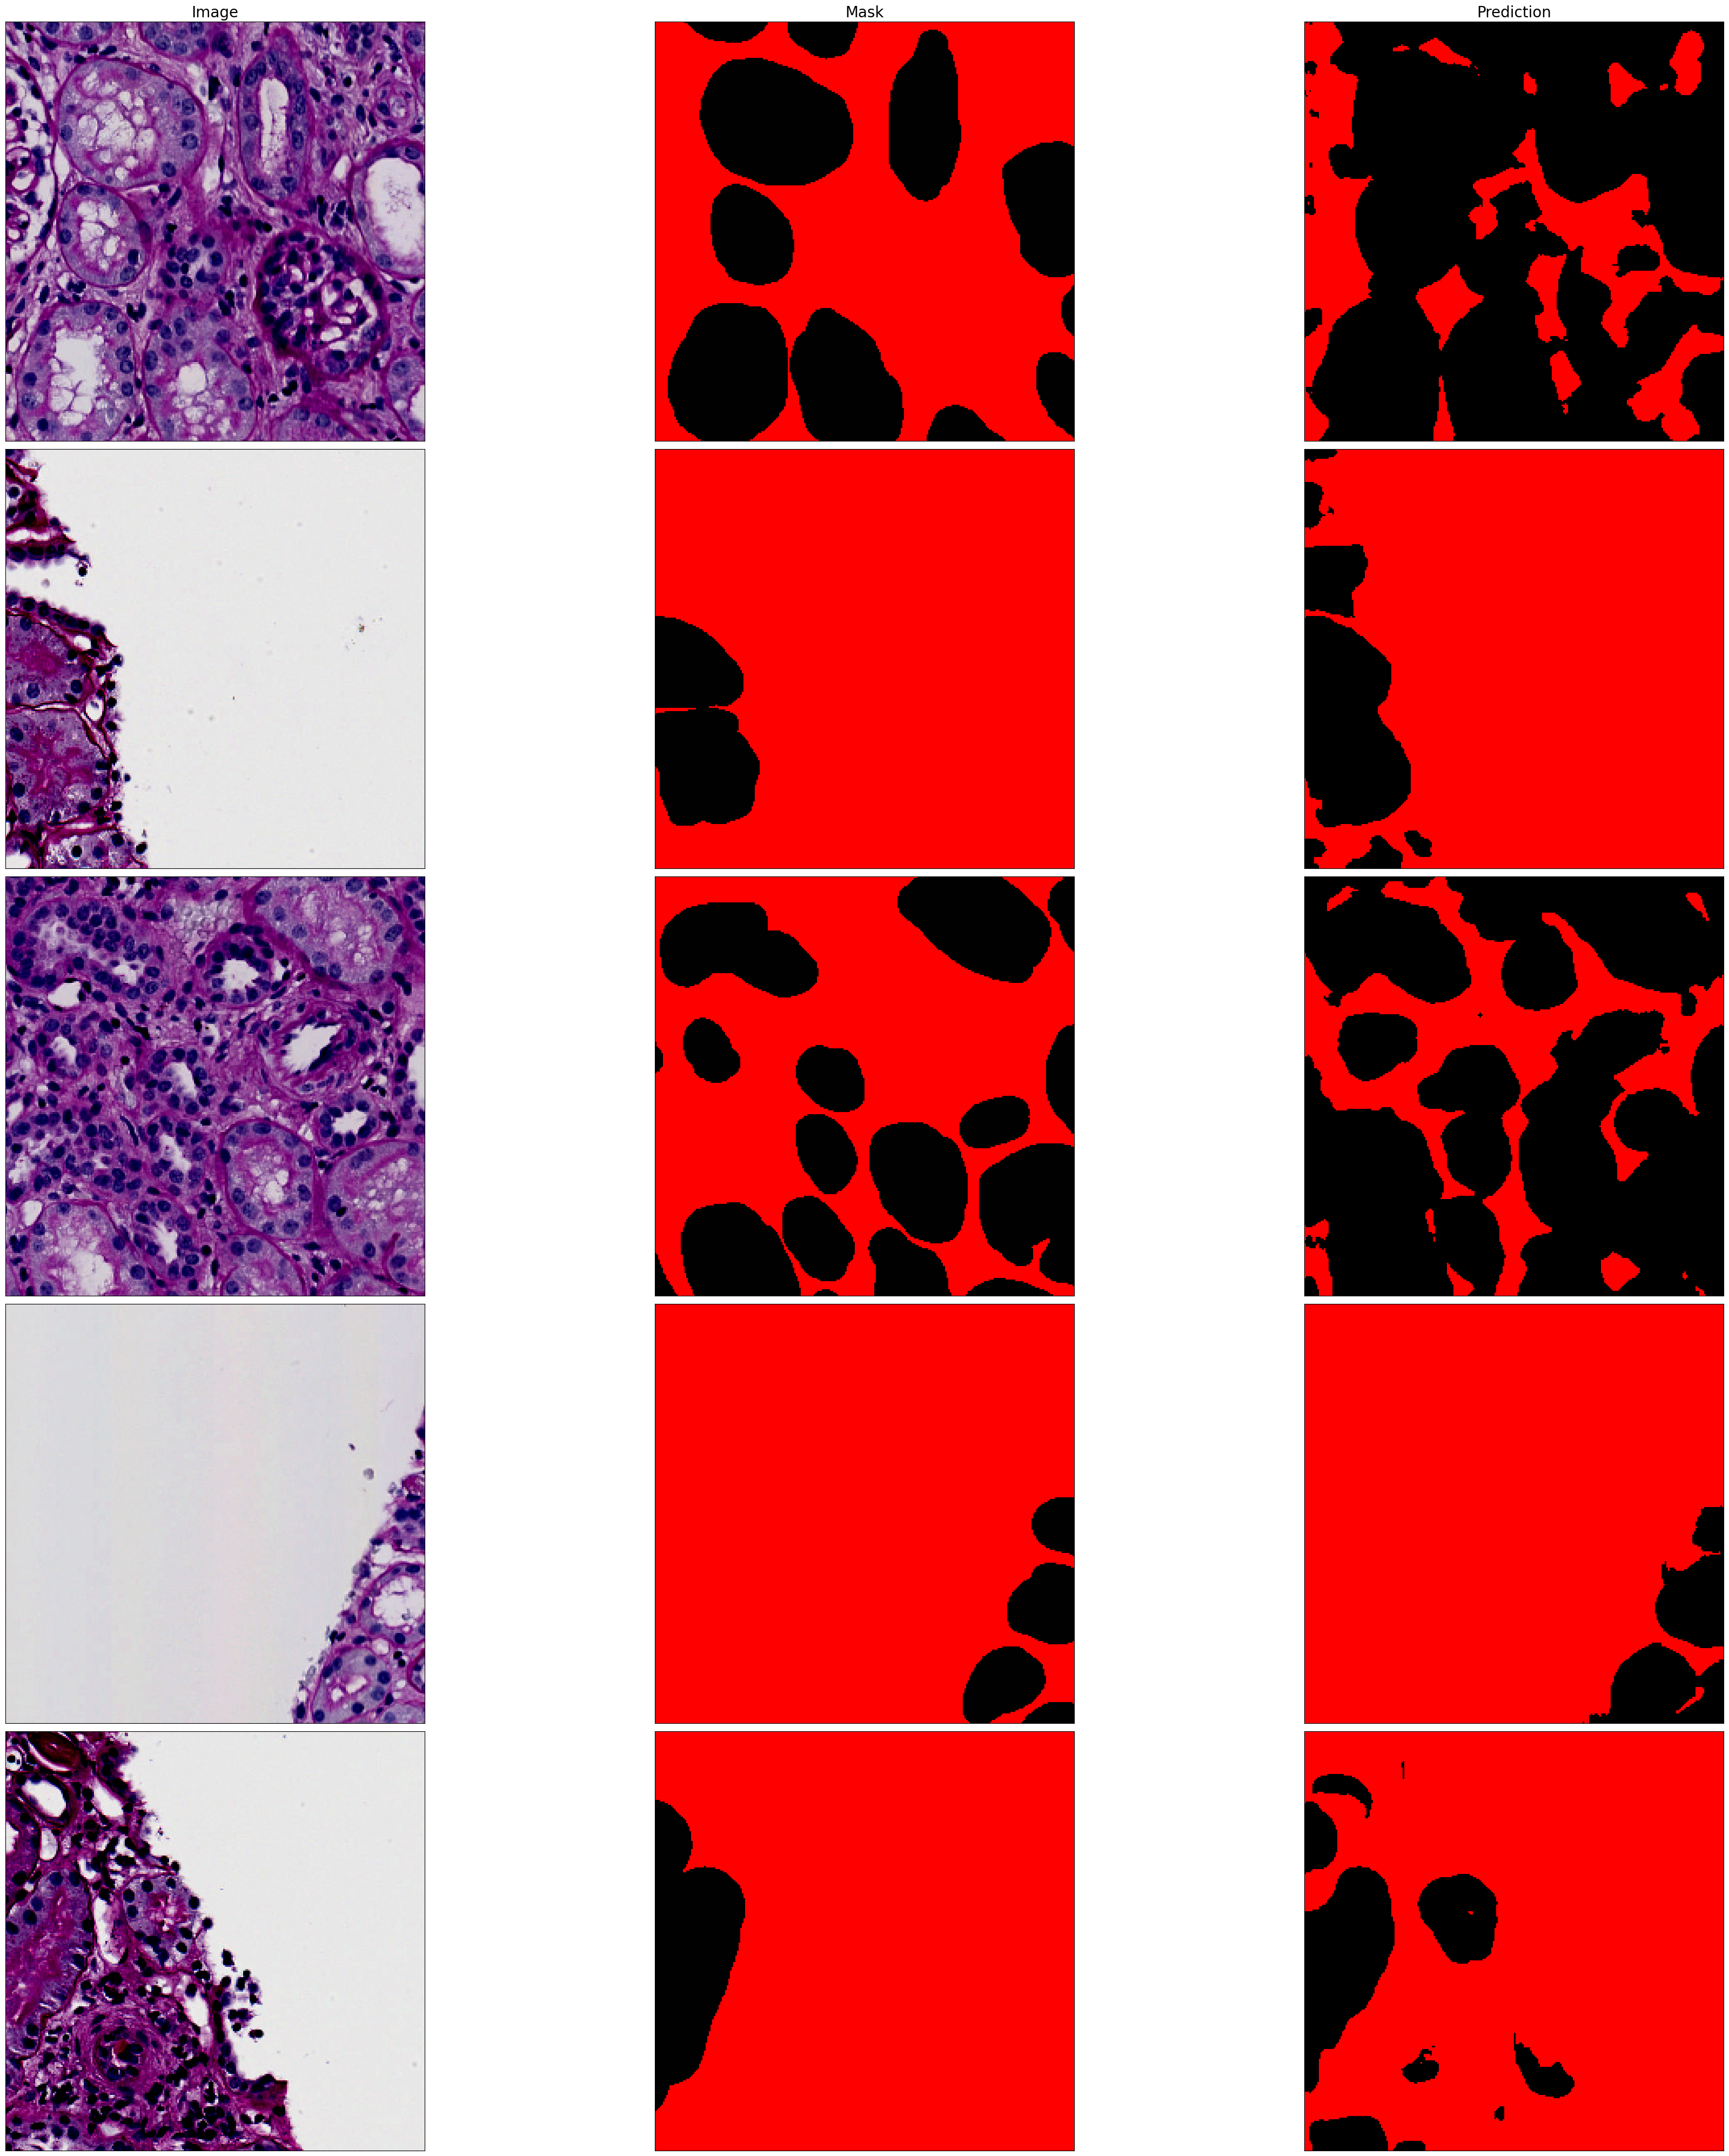

In [50]:
import random
random.seed(1)
samples = random.sample(range(len(test_dataset)), 5)

palette = [[255,0,0], [1,1,1]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(len(samples), 3, figsize=(60, 40), sharex='row', sharey='row', 
                         subplot_kw={'xticks':[], 'yticks':[]}, tight_layout=True)

for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=20) # set column label --> considered epoch


for i in range(len(samples)):
        image, mask = test_dataset[samples[i]]
        pred = model(torch.tensor(image).unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().detach().numpy()
      

        mask = Image.fromarray(np.array(mask.squeeze(0)).astype('uint8')).convert('L')
        pred = Image.fromarray(pred).convert('L')
        mask.putpalette(pal)
        pred.putpalette(pal)

        axes[i, 0].imshow(np.array(image).transpose(1, 2, 0));
        axes[i, 1].imshow(mask);
        axes[i, 2].imshow(pred);
        
fig.savefig(arch + '.png')